In [1]:
import detectron2
import torch
import copy
import pickle 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import detection_utils as utils 
from detectron2.data.detection_utils import annotations_to_instances
from tqdm import tqdm 

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for the mapepr
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils 
import detectron2.data.transforms as T

In [3]:
torch.__version__

'1.10.0'

In [4]:
!nvidia-smi

Sun Jan 22 19:49:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   48C    P0    66W / 300W |  26877MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

# Register the dataset so that it can be used by dataloader

In [5]:
def get_detectron_train_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "327_A1d_ASAP.xml", # data good
        "270_A1d_ASAP.xml", #looks good
        "131_B1e_ASAP_fixed.xml" #data good, 
        "41_A2c_ASAP_fixed.xml" #good, 
        "51_D1b_ASAP_fixed.xml" #good
        
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [6]:
def get_detectron_test_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "281_A1f_ASAP.xml", #looks good 

    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [7]:
train_data = get_detectron_train_data()
test_data = get_detectron_test_data()

In [8]:
# new_data = test_data[15:]
# print(len(new_data))
# test_data = test_data[:15]
# for d in new_data:
#     train_data.append(d)

In [9]:
print(len(train_data), len(test_data))

305 40


In [10]:
DatasetCatalog.register("nuclei_detection_train", get_detectron_train_data)
DatasetCatalog.register("nuclei_detection_test", get_detectron_test_data)

In [11]:
MetadataCatalog.get("nuclei_detection_train").thing_classes = ["cell"] 
MetadataCatalog.get("nuclei_detection_test").thing_classes = ["cell"] 

In [12]:
# we create the train dataloader here. Might make sense to play around with batch_size.
train_dataloader = build_detection_train_loader(
    train_data,
    mapper=DatasetMapper(is_train=True,
                         augmentations=[ 
                         ], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    total_batch_size = 1, 
    )

In [13]:
# test_dataloader = build_detection_test_loader(
#     test_data,
#     mapper=DatasetMapper(    is_train= True,
#                          augmentations=[], 
#                          use_instance_mask = True, 
#                          instance_mask_format = "polygon",
#                          image_format="BGR"), 
#     )

In [14]:
data = []
num = 0 
for x in tqdm(train_dataloader):
    if num > 10:
        break 
    print(x[0]["instances"])
    data.append(x)
    num += 1

2it [00:00,  7.70it/s]

Instances(num_instances=2, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[ 51.2813, 246.4863,  64.6992, 253.8633],
        [199.7637, 235.1973, 212.9961, 244.2051]])), gt_classes: tensor([0, 0]), gt_masks: PolygonMasks(num_instances=2)])
Instances(num_instances=38, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[222.8691, 208.9570, 234.0684, 221.0898],
        [224.4238, 191.6387, 240.2910, 200.0391],
        [212.3945, 184.0684, 222.4551, 194.4395],
        [200.9883, 201.0742, 215.7129, 217.4609],
        [183.2539, 203.7715, 195.3887, 219.4316],
        [188.6465, 189.4609, 201.8184, 199.0020],
        [184.0840, 187.5938, 191.2402, 193.2988],
        [171.1211, 180.4395, 184.7070, 192.0527],
        [161.5801, 169.4473, 175.9961, 179.5059],
        [142.6035, 177.6387, 160.1289, 192.7793],
        [ 96.5605, 192.4688, 115.7441, 204.6016],
        [ 91.1680, 207.5059, 102.7813, 217.8750],
        [ 47.9238, 199.7266,  60.3672, 210.6152],
    

4it [00:00,  6.39it/s]

Instances(num_instances=51, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[ 19.0938,  15.8965,  34.1543,  32.0664],
        [ 20.3066,  33.0781,  31.9316,  51.0684],
        [  3.1621, 233.9668,  11.1523, 253.1016],
        [  8.9453, 231.8633,  22.5078, 249.1055],
        [ 20.7207, 231.6543,  29.7617, 241.2207],
        [  7.9980, 224.1895,  25.1367, 232.4941],
        [ 13.4648, 212.9375,  27.4492, 226.1855],
        [ 26.5020, 207.5781,  32.9160, 216.1973],
        [ 36.8066, 235.6484,  48.0547, 252.8926],
        [ 59.4102, 208.9434,  66.0332, 218.5117],
        [ 69.5039, 171.8301,  93.1582, 196.3281],
        [ 69.7129, 197.0625,  84.2227, 207.6816],
        [111.2422, 233.0195, 135.2129, 246.8984],
        [138.4727, 214.8320, 154.5586, 242.1660],
        [132.9004, 186.5488, 150.8789, 208.2070],
        [111.5586, 139.1328, 127.1191, 153.9570],
        [ 83.1719, 139.0273, 106.9316, 159.1094],
        [ 34.9141, 138.5020,  46.4785, 151.2246],
        [  1.

5it [00:01,  3.40it/s]

Instances(num_instances=164, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[8.4533e+01, 4.7207e+00, 1.0074e+02, 1.4713e+01],
        [1.0119e+02, 3.6113e+00, 1.1995e+02, 2.5480e+01],
        [1.2705e+02, 3.0566e+00, 1.4026e+02, 2.0264e+01],
        [1.4315e+02, 8.6055e+00, 1.5270e+02, 2.0818e+01],
        [1.5347e+02, 1.5600e+01, 1.7157e+02, 2.4815e+01],
        [1.7024e+02, 1.0715e+01, 1.9255e+02, 2.5815e+01],
        [2.0687e+02, 1.4602e+01, 2.2974e+02, 2.3482e+01],
        [2.0609e+02, 7.4961e+00, 2.2252e+02, 1.5822e+01],
        [1.8489e+02, 1.6990e-01, 2.0643e+02, 1.4602e+01],
        [2.2774e+02, 1.6800e-01, 2.3329e+02, 7.7188e+00],
        [3.2367e+01, 2.2579e+02, 4.6791e+01, 2.3827e+02],
        [2.9355e+00, 2.2102e+02, 2.3596e+01, 2.3018e+02],
        [1.0940e-01, 2.0864e+02, 2.6033e+01, 2.2043e+02],
        [4.0078e+00, 1.8330e+02, 1.9990e+01, 1.9519e+02],
        [9.3672e+00, 1.6712e+02, 2.7885e+01, 1.8213e+02],
        [1.1902e+01, 1.5602e+02, 2.9150e+0

6it [00:01,  2.92it/s]

Instances(num_instances=134, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[9.5000e+01, 1.0101e+02, 1.0828e+02, 1.1448e+02],
        [8.9201e+01, 8.5859e+01, 1.0622e+02, 1.0401e+02],
        [1.0454e+02, 7.6881e+01, 1.2082e+02, 9.3156e+01],
        [1.1053e+02, 8.6795e+01, 1.2830e+02, 1.0924e+02],
        [1.0641e+02, 1.0831e+02, 1.2288e+02, 1.2402e+02],
        [1.1090e+02, 1.2103e+02, 1.2344e+02, 1.3619e+02],
        [1.2830e+02, 8.3428e+01, 1.4289e+02, 9.8955e+01],
        [1.3148e+02, 9.9891e+01, 1.4214e+02, 1.1411e+02],
        [1.2699e+02, 1.1074e+02, 1.3728e+02, 1.2889e+02],
        [1.3541e+02, 1.0999e+02, 1.4720e+02, 1.2589e+02],
        [1.2456e+02, 1.2982e+02, 1.3803e+02, 1.4161e+02],
        [1.3878e+02, 1.3038e+02, 1.4832e+02, 1.4573e+02],
        [1.5150e+02, 1.1355e+02, 1.6104e+02, 1.3394e+02],
        [1.6478e+02, 1.1093e+02, 1.7339e+02, 1.3375e+02],
        [1.5524e+02, 1.0850e+02, 1.6890e+02, 1.1579e+02],
        [1.7470e+02, 1.1261e+02, 1.8330e+0

9it [00:02,  4.49it/s]

Instances(num_instances=51, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[202.1152, 209.8691, 217.2910, 225.3496],
        [170.6504, 155.9434, 179.4531, 168.4902],
        [156.5879, 127.6172, 162.6582, 149.2676],
        [157.9023, 113.6543, 161.8496, 127.8184],
        [149.7090,  54.2656, 160.3301,  77.1309],
        [224.7793,  57.7051, 241.3711,  73.9941],
        [179.2441,  25.6387, 187.9805,  39.6992],
        [ 68.0801, 233.7246,  80.5508, 247.2910],
        [ 64.7871, 225.4434,  82.1465, 236.5176],
        [ 43.5371, 233.1250,  55.8086, 249.8848],
        [ 52.1172, 224.3457,  59.4004, 231.7285],
        [ 51.8184, 202.6973,  67.0820, 220.1563],
        [ 57.4043, 181.0469,  68.6777, 195.7129],
        [ 45.8320, 180.9473,  54.3125, 195.2148],
        [ 32.4629, 179.0527,  43.7363, 197.6094],
        [ 33.4609, 203.4941,  48.4258, 214.6680],
        [ 12.9102, 212.2754,  24.4824, 226.6406],
        [ 13.9063, 189.5273,  25.4805, 208.6816],
        [ 31.

11it [00:02,  5.39it/s]

Instances(num_instances=23, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[222.9355,   4.4883, 238.2930,  16.7734],
        [201.2129,  26.3281, 229.2090,  40.9023],
        [223.8398,  47.0371, 242.6328,  60.4609],
        [218.0859,  73.5000, 245.3184,  91.5254],
        [208.8828,  59.3066, 228.4414,  70.4316],
        [206.5820,  47.4219, 221.5391,  58.9277],
        [189.7070,  53.9414, 207.7324,  75.4180],
        [211.1836,  93.4434, 234.5781, 112.2363],
        [228.0586, 141.0000, 245.3164, 151.7383],
        [220.7715, 117.6055, 246.4668, 135.6309],
        [201.9785, 126.4258, 221.1543, 142.9180],
        [184.3379, 145.2188, 198.9102, 157.4902],
        [219.2363, 148.2871, 229.9766, 160.9434],
        [211.5664, 159.7930, 227.6738, 173.2148],
        [207.3477, 177.4336, 231.5098, 191.6250],
        [230.7422, 194.6934, 247.2344, 211.1836],
        [187.4063, 193.5410, 213.8691, 213.8691],
        [157.4902, 191.2402, 170.5313, 208.1152],
        [159.

11it [00:02,  4.70it/s]


# Visualize Training Data

In [15]:
from detectron2.utils.visualizer import ColorMode, Visualizer
data[0][0]

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/Images/131_B1e_ASAP_fixed_132.jpg',
 'height': 256,
 'width': 256,
 'image_id': '131_B1e_ASAP_fixed_132',
 'image': tensor([[[165, 140, 177,  ..., 146, 145, 184],
          [184, 159, 177,  ..., 142, 145, 171],
          [184, 164, 182,  ..., 136, 152, 210],
          ...,
          [142, 154, 162,  ..., 224, 227, 222],
          [141, 155, 160,  ..., 234, 234, 221],
          [132, 133, 136,  ..., 241, 233, 221]],
 
         [[131, 100, 130,  ...,  84,  90, 137],
          [138, 109, 123,  ...,  82,  91, 122],
          [128, 108, 125,  ...,  78,  96, 155],
          ...,
          [ 92, 106, 114,  ..., 218, 215, 200],
          [ 95, 102, 107,  ..., 223, 222, 210],
          [ 86,  77,  81,  ..., 220, 219, 221]],
 
         [[231, 195, 228,  ..., 144, 159, 213],
          [245, 209, 223,  ..., 142, 158, 196],
          [247

In [16]:
data[0][0]["instances"].gt_classes

tensor([0, 0])

In [17]:
data[0][0]["image"].shape

torch.Size([3, 256, 256])

In [18]:
img = cv2.imread(data[0][0]["file_name"])

<Figure size 1000x1000 with 0 Axes>

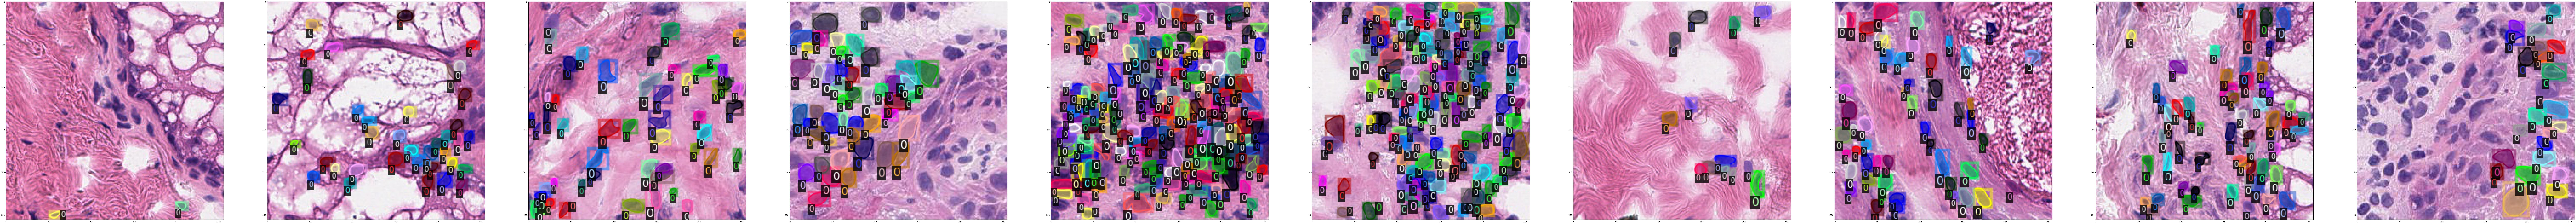

In [19]:
fig = plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,10) 
f.set_size_inches(256, 256)
for i in range(len(data)-1):
    img = cv2.imread(data[i][0]["file_name"])
    v = Visualizer(img)
    v = v.overlay_instances(boxes=data[i][0]["instances"].gt_boxes, labels=data[i][0]["instances"].gt_classes.numpy(), masks=data[i][0]["instances"].gt_masks)
    axarr[i].imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
img = cv2.imread(data[0][0]["file_name"])
v = Visualizer(img)

In [21]:
v = v.overlay_instances(boxes=data[0][0]["instances"].gt_boxes, labels=data[0][0]["instances"].gt_classes.numpy(), masks=data[0][0]["instances"].gt_masks)

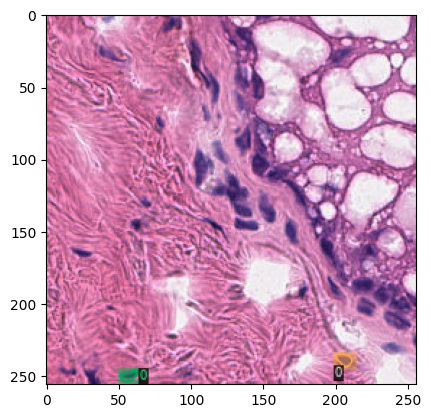

In [22]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

# Training the Segmentation Model

In [23]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, HookBase
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.utils.comm as comm


In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = "nuclei_detection_train"
cfg.DATASETS.TEST = "nuclei_detection_test"
cfg.DATASETS.VAL = "nuclei_detection_test"

cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.BASE_LR = 1e-5
num_epochs = 100
cfg.SOLVER.MAX_ITER = int((len(train_data)/cfg.SOLVER.IMS_PER_BATCH)*num_epochs) #100 seems to work really well 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [25]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name="nuclei_detection_test", output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper=DatasetMapper(is_train=True,
             augmentations=[ 
                    T.RandomBrightness(0.5, 2),
                    T.RandomContrast(0.5, 2),
                    T.RandomSaturation(0.5, 2),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
             ], 
             use_instance_mask = True, 
             instance_mask_format = "polygon",
             image_format="BGR"
        )
        return build_detection_train_loader(cfg, mapper=mapper)
    
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(
                    total_val_loss=losses_reduced, 
                    **loss_dict_reduced
                )

In [26]:
trainer = Trainer(cfg) 

[01/22 19:51:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/22 19:51:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomBrightness(intensity_min=0.5, intensity_max=2), RandomContrast(intensity_min=0.5, intensity_max=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomFlip(prob=0.5), RandomFlip(prob=0.5, horizontal=False, vertical=True)]
[01/22 19:51:18 d2.data.build]: Removed 0 images with no usable annotations. 305 images left.
[01/22 19:51:18 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 16627        |
|            |              |
[01/22 19:51:18 d2.data.build]: Using training sampler TrainingSampler
[01/22 19:51:18 d2.data.common]: Serializing 305 elements to byte tensors and concatenating them all ...
[01/22 19:52:18 d2.data.common]: Serialized dataset takes 602.24 MiB
WARNING [01/22 19:52:18 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


In [27]:
# Validation loss
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

[01/22 19:52:19 d2.data.build]: Removed 0 images with no usable annotations. 40 images left.
[01/22 19:52:19 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 1036         |
|            |              |
[01/22 19:52:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/22 19:52:19 d2.data.build]: Using training sampler TrainingSampler
[01/22 19:52:19 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/22 19:52:23 d2.data.common]: Serialized dataset takes 37.65 MiB


In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()
checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/22 19:52:23 d2.engine.train_loop]: Starting training from iteration 0


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(t

[01/22 19:52:47 d2.utils.events]:  eta: 0:21:47  iter: 19  total_loss: 9.156  loss_cls: 0.8603  loss_box_reg: 0.2822  loss_mask: 0.696  loss_rpn_cls: 6.69  loss_rpn_loc: 0.6443  total_val_loss: 4.26  val_loss_cls: 0.8023  val_loss_box_reg: 0.4488  val_loss_mask: 0.6963  val_loss_rpn_cls: 2.165  val_loss_rpn_loc: 0.1217  time: 0.4023  data_time: 0.2459  lr: 1.9981e-07  max_mem: 3049M
[01/22 19:53:07 d2.utils.events]:  eta: 0:21:28  iter: 39  total_loss: 9.039  loss_cls: 0.8449  loss_box_reg: 0.3145  loss_mask: 0.6957  loss_rpn_cls: 6.5  loss_rpn_loc: 0.6307  total_val_loss: 4.311  val_loss_cls: 0.79  val_loss_box_reg: 0.4474  val_loss_mask: 0.696  val_loss_rpn_cls: 2.234  val_loss_rpn_loc: 0.1234  time: 0.5304  data_time: 0.0500  lr: 3.9961e-07  max_mem: 3049M
[01/22 19:53:22 d2.utils.events]:  eta: 0:21:11  iter: 59  total_loss: 8.694  loss_cls: 0.8351  loss_box_reg: 0.2754  loss_mask: 0.6952  loss_rpn_cls: 6.25  loss_rpn_loc: 0.6472  total_val_loss: 4.219  val_loss_cls: 0.7804  val_lo

[01/22 19:58:27 d2.utils.events]:  eta: 0:19:27  iter: 459  total_loss: 2.624  loss_cls: 0.4997  loss_box_reg: 0.5833  loss_mask: 0.6521  loss_rpn_cls: 0.4973  loss_rpn_loc: 0.3797  total_val_loss: 2.267  val_loss_cls: 0.4921  val_loss_box_reg: 0.2218  val_loss_mask: 0.632  val_loss_rpn_cls: 0.8313  val_loss_rpn_loc: 0.1316  time: 0.3786  data_time: 0.1277  lr: 4.5954e-06  max_mem: 3066M
[01/22 19:58:43 d2.utils.events]:  eta: 0:19:20  iter: 479  total_loss: 2.616  loss_cls: 0.489  loss_box_reg: 0.5525  loss_mask: 0.6475  loss_rpn_cls: 0.5007  loss_rpn_loc: 0.3536  total_val_loss: 2.281  val_loss_cls: 0.4779  val_loss_box_reg: 0.2106  val_loss_mask: 0.6262  val_loss_rpn_cls: 0.826  val_loss_rpn_loc: 0.1172  time: 0.3781  data_time: 0.0517  lr: 4.7952e-06  max_mem: 3066M
[01/22 19:58:58 d2.utils.events]:  eta: 0:19:12  iter: 499  total_loss: 2.658  loss_cls: 0.4889  loss_box_reg: 0.5846  loss_mask: 0.6421  loss_rpn_cls: 0.5125  loss_rpn_loc: 0.4112  total_val_loss: 2.35  val_loss_cls: 0

[01/22 20:04:00 d2.utils.events]:  eta: 0:16:52  iter: 899  total_loss: 2.342  loss_cls: 0.4303  loss_box_reg: 0.6002  loss_mask: 0.5445  loss_rpn_cls: 0.4032  loss_rpn_loc: 0.3508  total_val_loss: 2.172  val_loss_cls: 0.3858  val_loss_box_reg: 0.1165  val_loss_mask: 0.4973  val_loss_rpn_cls: 1.007  val_loss_rpn_loc: 0.1418  time: 0.3730  data_time: 0.0408  lr: 8.991e-06  max_mem: 3066M
[01/22 20:04:16 d2.utils.events]:  eta: 0:16:45  iter: 919  total_loss: 2.326  loss_cls: 0.4255  loss_box_reg: 0.6  loss_mask: 0.5327  loss_rpn_cls: 0.3891  loss_rpn_loc: 0.3467  total_val_loss: 2.152  val_loss_cls: 0.3815  val_loss_box_reg: 0.111  val_loss_mask: 0.49  val_loss_rpn_cls: 1.019  val_loss_rpn_loc: 0.1409  time: 0.3728  data_time: 0.0391  lr: 9.1908e-06  max_mem: 3066M
[01/22 20:04:30 d2.utils.events]:  eta: 0:16:39  iter: 939  total_loss: 2.313  loss_cls: 0.4197  loss_box_reg: 0.6157  loss_mask: 0.5347  loss_rpn_cls: 0.3925  loss_rpn_loc: 0.3567  total_val_loss: 2.2  val_loss_cls: 0.3851  

# Inference using Model 

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import os

model_path="model_final.pth"#outputs/
base_model= "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
n=1

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(base_model))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = n
# cfg.OUTPUT_DIR=output_dir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_path)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.65

predictor = DefaultPredictor(cfg)


In [ ]:
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
# # cfg.MODEL.ROI_HEADS.PROPOSAL_APPEND_GT = True
# predictor = DefaultPredictor(cfg)

## Inference on test image

In [ ]:
test_dataloader = build_detection_test_loader(
    test_data,
    mapper=DatasetMapper(is_train= True,
                         augmentations=[], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    )

In [ ]:
data = []
num = 0 
for x in tqdm(test_dataloader):
    if num > 10:
        break 
    print(x[0]["instances"])
    data.append(x)
    num += 1

In [ ]:
fig = plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,10) 
f.set_size_inches(256, 256)
for i in range(len(data)-1):
    img = cv2.imread(data[i][0]["file_name"])
    v = Visualizer(img)
    v = v.overlay_instances(boxes=data[i][0]["instances"].gt_boxes, labels=data[i][0]["instances"].gt_classes.numpy(), masks=data[i][0]["instances"].gt_masks)
    axarr[i].imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img = cv2.imread(data[4][0]["file_name"])
v = Visualizer(img)

In [ ]:
v = v.overlay_instances(boxes=data[4][0]["instances"].gt_boxes, labels=data[4][0]["instances"].gt_classes.numpy(), masks=data[4][0]["instances"].gt_masks)


In [ ]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
outputs = predictor(img) # now predict on this image 

In [ ]:
len(outputs["instances"])

In [ ]:
outputs["instances"]._fields

In [ ]:
outputs = outputs["instances"].to("cpu")

In [ ]:
areas = outputs._fields["pred_boxes"].area()
bool_array = []
for i in range(len(areas)):
    if areas[i] < 30**2 and areas[i] > 13*13: 
        bool_array.append(True)
    else:
        bool_array.append(False)
bool_array = torch.tensor(bool_array)

In [ ]:
outputs._fields["pred_boxes"][bool_array]

In [ ]:
plt.figure(figsize=(512/100, 512/100))

v = Visualizer(img, scale=1)
v._default_font_size = 5
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# v = v.overlay_instances(masks = outputs["instances"]._fields["pred_masks"].to("cpu"))
v = v.overlay_instances(masks = outputs._fields["pred_masks"][bool_array], boxes = outputs._fields["pred_boxes"][bool_array])

plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))

plt.show()

## Inference on test dataset

In [62]:
# from detectron2.evaluation import DatasetEvaluator
# from detectron2.evaluation import inference_on_dataset

In [83]:
 #import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

directory = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/output/"

In [84]:
#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("nuclei_detection_test", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "nuclei_detection_test")

WARNING [01/22 19:14:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/22 19:14:45 d2.evaluation.coco_evaluation]: Trying to convert 'nuclei_detection_test' to COCO format ...
[01/22 19:14:45 d2.data.datasets.coco]: Converting annotations of dataset 'nuclei_detection_test' to COCO format ...)
[01/22 19:14:46 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/22 19:14:46 d2.data.datasets.coco]: Conversion finished, #images: 40, #annotations: 1036
[01/22 19:14:46 d2.data.datasets.coco]: Caching COCO format annotations at './output/nuclei_detection_test_coco_format.json' ...
[01/22 19:14:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/22 19:14:51 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/22 19:14:54 

In [85]:
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/22 19:15:03 d2.evaluation.evaluator]: Start inference on 40 batches
[01/22 19:15:04 d2.evaluation.evaluator]: Inference done 11/40. Dataloading: 0.0006 s/iter. Inference: 0.0492 s/iter. Eval: 0.0109 s/iter. Total: 0.0608 s/iter. ETA=0:00:01
[01/22 19:15:07 d2.evaluation.evaluator]: Total inference time: 0:00:02.463497 (0.070386 s / iter per device, on 1 devices)
[01/22 19:15:07 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.049539 s / iter per device, on 1 devices)
[01/22 19:15:07 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/22 19:15:07 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/22 19:15:07 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/22 19:15:07 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/22 19:15:07 d2.evaluation.fast_eval_api]: COCOeval

OrderedDict([('bbox',
              {'AP': 0.8760402714220914,
               'AP50': 4.2511687521714965,
               'AP75': 0.09631609012056039,
               'APs': 0.8766622188435695,
               'APm': 1.6831683168316833,
               'APl': nan}),
             ('segm',
              {'AP': 0.4847019564015854,
               'AP50': 2.5085273099266985,
               'AP75': 0.06312617660179165,
               'APs': 0.4905034958061096,
               'APm': 0.0,
               'APl': nan})])

In [32]:
!nvidia-smi

Tue Jan 17 23:14:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    51W / 300W |  11271MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   